<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# Introduction to the `ErosionDeposition` component

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial introduces the `ErosionDeposition` component, which simulates erosion and deposition in a river network over long time scales.

## Theory and Overview

`ErosionDeposition` models fluvial processes using the approach described by Davy and Lague (2009). The basic goal is to calculate rates of erosion or deposition in the various branches of a river network that is embedded in a gridded landscape (see, e.g., Tucker and Hancock, 2010). The literature has a number of different approaches to this problem. Some models assume transport-limited conditions, such that erosion or deposition result from local imbalances in sediment transport capacity (see, e.g., Willgoose, 2018). Some assume detachment-limited conditions, such that any eroded sediment is entirely removed  (e.g., Howard, 1994; Whipple and Tucker, 1999; Tucker and Whipple, 2002). Still others allow for both erosion of detachment-resistant material (bedrock or cohesive sediments), and re-deposition of that material. The Davy-Lague approach falls in the latter category, and is similar to the approach used in some shorter-term morphodynamic models as well as agricultural soil erosion models. The basic idea involves conservation of sediment mass in the water column of a river. One calculates the rate of entrainment of sediment from the bed into the water as a function of discharge and local slope. The bed also accumulates sediment that settles out from the water column, at a rate that depends on sediment concentration (treated as the ratio of sediment flux to water discharge) and a settling-velocity parameter.

The theory behind using this kind of dual erosion-deposition approach in the context of fluvial landscape evolution is described by Davy and Lague (2009). Tucker and Hancock (2010) provide a review of landscape evolution modeling that compares this with other approaches to fluvial erosion/deposition theory. The equations used in the Landlab `ErosionDeposition` component are described by Barnhart et al. (2019) as part of the *terrainBento* collection of Landlab-based landscape evolution models, which includes models that use `ErosionDeposition`.

In [1]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid
from landlab.components import ErosionDeposition, FlowAccumulator
from landlab.plot import imshow_grid

Look at the top-level internal documentation for the `ErosionDeposition` component:

In [2]:
print(ErosionDeposition.__doc__)


    Erosion-Deposition model in the style of Davy and Lague (2009). It uses a
    mass balance approach across the total sediment mass both in the bed and
    in transport coupled with explicit representation of the sediment
    transport lengthscale (the "xi-q" model) to derive a range of erosional
    and depositional responses in river channels.

    This implementation is close to the Davy & Lague scheme, with a few
    deviations:

        - A fraction of the eroded sediment is permitted to enter the wash load,
          and lost to the mass balance (`F_f`).

        - Here an incision threshold :math:`\omega` is permitted, where it was not by Davy &
          Lague. It is implemented with an exponentially smoothed form to prevent
          discontinuities in the parameter space. See the
          :py:class:`~landlab.components.StreamPowerSmoothThresholdEroder`
          for more documentation.

        - This component uses an "effective" settling velocity, v_s, as one of its
  

The `__init__` docstring lists the parameters for this component:

In [3]:
print(ErosionDeposition.__init__.__doc__)

Initialize the ErosionDeposition model.

        Parameters
        ----------
        grid : ModelGrid
            Landlab ModelGrid object
        K : float, field name, or array
            Erodibility for substrate (units vary).
        v_s : float
            Effective settling velocity for chosen grain size metric [L/T].
        m_sp : float
            Discharge exponent (units vary)
        n_sp : float
            Slope exponent (units vary)
        sp_crit : float, field name, or array
            Critical stream power to erode substrate [E/(TL^2)]
        F_f : float
            Fraction of eroded material that turns into "fines" that do not
            contribute to (coarse) sediment load. Defaults to zero.
        discharge_field : float, field name, or array
            Discharge [L^2/T]. The default is to use the grid field
            'surface_water__discharge', which is simply drainage area
            multiplied by the default rainfall rate (1 m/yr). To use custom
   

Set some parameters:

In [4]:
# Parameters
nrows = 41
ncols = 41
dx = 100.0
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

run_duration = 120000.0  # duration of run, yr
dt = 100.0  # time-step duration, yr
plot_every = 40000.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

Create a grid with one side open:

In [5]:
mg = HexModelGrid(
    (nrows, ncols), spacing=dx, node_layout="rect", orientation="vertical"
)
z = mg.add_zeros("topographic__elevation", at="node")
# add some roughness, as this lets "natural" channel planforms arise
np.random.seed(0)
initial_roughness = np.random.rand(z.size)
z[:] += initial_roughness
z[mg.core_nodes] += initial_elevation
z[mg.boundary_nodes] = 0.0

# close off boundaries on 3 sides
is_closed_boundary = np.logical_and(
    mg.status_at_node != mg.BC_NODE_IS_CORE,
    mg.x_of_node < (np.amax(mg.x_of_node) - 0.5 * dx),
)
mg.status_at_node[is_closed_boundary] = mg.BC_NODE_IS_CLOSED

Instantiate components:

In [6]:
fr = FlowAccumulator(mg, depression_finder="DepressionFinderAndRouter")
ed = ErosionDeposition(
    mg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)

Run the model in a loop to evolve topography on the uplifted block:

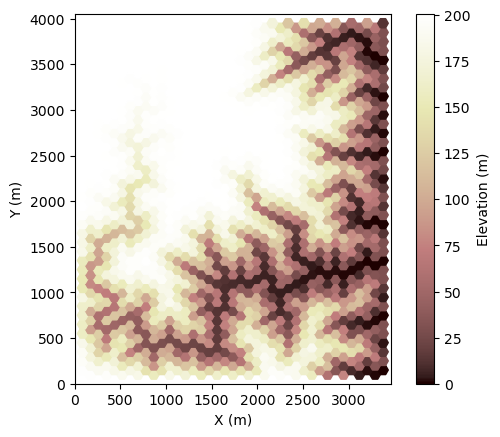

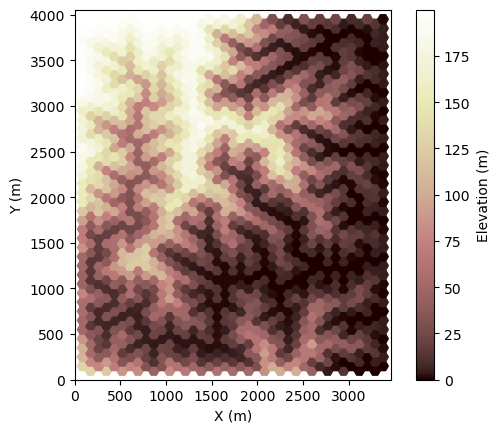

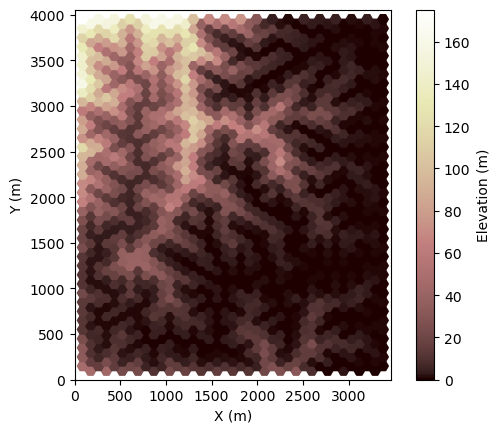

In [7]:
for i in range(1, nsteps + 1):
    # route flow
    fr.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            mg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every

## References

Barnhart, K. R., Glade, R. C., Shobe, C. M., & Tucker, G. E. (2019). Terrainbento 1.0: a Python package for multi-model analysis in long-term drainage basin evolution. Geoscientific Model Development, 12(4), 1267-1297.

Davy, P., & Lague, D. (2009). Fluvial erosion/transport equation of landscape evolution models revisited. Journal of Geophysical Research: Earth Surface, 114(F3).

Howard, A. D. (1994). A detachment‐limited model of drainage basin evolution. Water resources research, 30(7), 2261-2285.

Tucker, G. E., & Hancock, G. R. (2010). Modelling landscape evolution. Earth Surface Processes and Landforms, 35(1), 28-50.

Tucker, G. E., & Whipple, K. X. (2002). Topographic outcomes predicted by stream erosion models: Sensitivity analysis and intermodel comparison. Journal of Geophysical Research: Solid Earth, 107(B9), ETG-1.

Whipple, K. X., & Tucker, G. E. (1999). Dynamics of the stream‐power river incision model: Implications for height limits of mountain ranges, landscape response timescales, and research needs. Journal of Geophysical Research: Solid Earth, 104(B8), 17661-17674.

Willgoose, G. (2018). Principles of soilscape and landscape evolution. Cambridge University Press.

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>